In [1]:
!pip install OpenCC
!pip install transformers
!pip install sklearn
!pip install imblearn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.5 MB/s eta 0:00:00a 0:00:01
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 47.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 kB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 48.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 102.4 MB/s eta 0:00:00
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is h

In [2]:
from collections import defaultdict
import json
import re
import matplotlib.pyplot as plt
import numpy as np

# 模型评估函数
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from torchvision.transforms import v2
import torchvision
torchvision.disable_beta_transforms_warning()

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertModel
import torch
from torch.utils.data import Dataset, DataLoader
import json
import re
from pathlib import Path
from typing import List, Dict
from tqdm import tqdm

from torch.utils.data import WeightedRandomSampler
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler

import random

from transformers import BertForMaskedLM, BertTokenizer
# 增加分层采样器（DataLoader处修改）
from torch.utils.data import WeightedRandomSampler

from opencc import OpenCC

# 修改为带warmup的调度
from transformers import get_linear_schedule_with_warmup

import torch
from torch.distributed._tensor import DTensor

In [3]:
print(torch.__version__)  # 应 ≥ 2.1.0

2.5.1+cu124


In [4]:
def read_train_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # 去除行首尾的空白字符（如换行符）
            if line:  # 跳过空行
                try:
                    item = json.loads(line)  # 将 JSON 字符串解析为 Python 字典
                    data.append(item)
                except json.JSONDecodeError as e:
                    print(f"解析第 {len(data)+1} 行时出错: {e}")
    return data

# 使用示例
file_path = 'Xeon3NLP_round1_train_20210524.txt'  # 替换为实际文件路径
train_data = read_train_data(file_path)
print(f"成功读取 {len(train_data)} 条数据")
# 查看第一条数据
if train_data:
    print(train_data[0])

成功读取 20000 条数据
{'text_id': 'e225b9fd36b8914f42c188fc92e8918f', 'query': '河南省巩义市新华路街道办事处桐和街6号钢苑新区3号楼一单元', 'candidate': [{'text': '巩义市桐和街', 'label': '不匹配'}, {'text': '桐和街依家小店', 'label': '不匹配'}, {'text': '桐和街CHANG六LIULIU', 'label': '不匹配'}, {'text': '桐和街佳乐钢琴', 'label': '不匹配'}, {'text': '世博领秀城南门桐和街囍饭食堂', 'label': '不匹配'}]}


In [5]:
# 对抗样本生成函数

def adversarial_augmentation(text, prob=0.1):
    """
    对地址文本进行对抗性增强
    :param text: 原始文本
    :param prob: 每个字符被修改的概率
    :return: 增强后的文本
    """
    # 常见地址字符替换表（形近字/同音字）
    substitution_map = {
        '街': ['接', '階'],
        '路': ['陸', '露'],
        '号': ['號', '豪'],
        '栋': ['東', '冻'],
        '区': ['區', '丘'],
        '市': ['是', '事'],
        '县': ['縣', '现']
    }
    
    chars = list(text)
    new_chars = []
    for char in chars:
        if random.random() < prob:
            # 50%概率替换 30%概率插入 20%概率删除
            op = random.choices(['replace', 'insert', 'delete'], weights=[5,3,2])[0]
            
            if op == 'replace':
                new_char = substitution_map.get(char, [char])
                new_chars.append(random.choice(new_char))
            elif op == 'insert':
                new_chars.append(char)
                new_chars.append(random.choice(list(substitution_map.keys())))
            elif op == 'delete':
                continue
        else:
            new_chars.append(char)
    return ''.join(new_chars)

In [6]:
def analyze_label_distribution(file_path):
    """改进版分析函数：自动过滤错误数据并验证"""
    valid_data = []  # 存储有效数据
    error_lines = []  # 记录错误行号
    label_counter = defaultdict(int)
    total = 0
    valid_labels = {"完全匹配", "部分匹配", "不匹配"}
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line: continue
            
            # ========== 错误数据过滤 ==========
            try:
                # 预处理常见格式错误
                line = re.sub(r'\u3000', '', line)  # 全角空格
                line = re.sub(r'[“”]', '"', line)   # 中文引号替换
                line = re.sub(r'：', ':', line)      # 中文冒号替换
                
                # 解析JSON并验证结构
                item = json.loads(line)
                if not all(k in item for k in ['text_id', 'query', 'candidate']):
                    raise ValueError("缺少必要字段")
                    
                # 验证候选数据格式
                valid_candidates = []
                for cand in item.get('candidate', []):
                    if not isinstance(cand, dict):
                        continue
                        
                    # 清洗标签
                    raw_label = cand.get('label', '')
                    clean_label = re.sub(r'[^匹配不部分完全]', '', raw_label)
                    
                    # 标准化标签
                    if clean_label in valid_labels:
                        label = clean_label
                    elif '不匹配' in raw_label:
                        label = '不匹配'
                    elif '部分' in raw_label:
                        label = '部分匹配'
                    elif '完全' in raw_label:
                        label = '完全匹配'
                    else:
                        continue  # 跳过无效标签的候选
                        
                    valid_candidates.append({
                        'text': cand.get('text', ''),
                        'label': label
                    })
                    label_counter[label] += 1
                    total += 1
                
                # 仅保留有效候选的数据
                if valid_candidates:
                    valid_data.append({
                        'text_id': item['text_id'],
                        'query': item['query'],
                        'candidate': valid_candidates
                    })
                    
            except (json.JSONDecodeError, KeyError, ValueError) as e:
                error_lines.append(line_num)
                continue

    # ========== 数据验证 ==========
    print("=== 数据清洗报告 ===")
    print(f"原始文件总行数：{line_num}")
    print(f"发现错误行数：{len(error_lines)} (行号：{error_lines[:5]}{'...' if len(error_lines)>5 else ''})")
    print(f"有效数据条目：{len(valid_data)}")
    print(f"有效候选总数：{total}")
    
    # 标签分布统计
    print("\n=== 标签分布 ===")
    print(f"{'标签类别':<10}|{'数量':<8}|{'比例':<10}")
    print("-"*30)
    for label in valid_labels:
        count = label_counter[label]
        print(f"{label:<10}|{count:<8}|{count/total:.2%}")

    # ========== 二次验证 ==========
    print("\n=== 数据完整性验证 ===")
    verify_errors = 0
    for item in valid_data[:100]:  # 抽样验证前100条
        try:
            json.dumps(item)  # 验证可序列化
            for cand in item['candidate']:
                if cand['label'] not in valid_labels:
                    verify_errors += 1
        except:
            verify_errors += 1
    print(f"抽样验证错误数：{verify_errors}")

    return valid_data

# 使用示例
cleaned_data = analyze_label_distribution("Xeon3NLP_round1_train_20210524.txt")

=== 数据清洗报告 ===
原始文件总行数：20000
发现错误行数：3 (行号：[4775, 8654, 9803])
有效数据条目：19997
有效候选总数：96411

=== 标签分布 ===
标签类别      |数量      |比例        
------------------------------
部分匹配      |31890   |33.08%
不匹配       |58514   |60.69%
完全匹配      |6007    |6.23%

=== 数据完整性验证 ===
抽样验证错误数：0


In [7]:
# ========== 增强地址特征预处理 ==========
def address_specific_preprocessing(text):
    """
    地址文本专用预处理：
    1. 标准化汉字（繁转简）
    2. 统一编号格式（如"3号楼"转"3栋"）
    3. 去除非地址相关字符
    """
    # 繁简转换（需安装opencc）
    text = OpenCC('t2s').convert(text)  
    
    # 统一编号
    text = re.sub(r'(\d+)号楼', r'\1栋', text)
    text = re.sub(r'(\d+)-(\d+)', r'\1单元\2室', text)
    
    # 去除电商平台后缀
    text = re.sub(r'(快递驿站|菜鸟驿站|第\d+分店)\b', '', text)
    
    return text.strip()

In [8]:
# ========== 数据预处理 ==========
class AddressDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128, augment=False):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.samples = []
        self.labels = []  # 新增labels属性用于存储所有标签
        self.augment = augment  # 是否启用增强
        
        # 展开所有候选对
        label_map = {"完全匹配":0, "部分匹配":1, "不匹配":2}
        
        for item in data:
            for cand in item["candidate"]:
                # 原始样本
                self._add_sample(item["query"], cand["text"], cand["label"], label_map)
                
                # 数据增强：为每个样本生成一个对抗样本
                if self.augment:
                    aug_text = adversarial_augmentation(cand["text"])
                    self._add_sample(item["query"], aug_text, cand["label"], label_map)
    
    def _add_sample(self, query, text, label, label_map):
        """添加样本的辅助函数"""
        self.samples.append((
            query,
            text,
            label_map.get(label, 2)
        ))
        self.labels.append(label_map.get(label, 2))
                
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        query, cand_text, label = self.samples[idx]
        
        # 添加地址专用预处理
        query = address_specific_preprocessing(query)
        cand_text = address_specific_preprocessing(cand_text)
        
        # BERT输入格式： [CLS] query [SEP] candidate [SEP]
        encoding = self.tokenizer.encode_plus(
            text=query,
            text_pair=cand_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=torch.tensor([1.0, 1.0, 1.0]), gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        alpha = self.alpha.to(inputs.device)[targets]  # 按target索引获取alpha
        focal_loss = alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [13]:
# ========== 地址领域预训练（改进版） ==========
class MLMDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128, mask_prob=0.15, max_ngram=3):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.max_ngram = max_ngram
        self.examples = []
        
        # 收集所有文本及其标签信息
        self.text_infos = []
        for item in data:
            # 添加query文本（无标签）
            self.text_infos.append({
                "text": item["query"],
                "label": None
            })
            # 添加候选文本及对应标签
            for cand in item["candidate"]:
                self.text_infos.append({
                    "text": cand["text"],
                    "label": cand.get("label", None)
                })

    def __len__(self):
        return len(self.text_infos)

    def __getitem__(self, idx):
        text_info = self.text_infos[idx]
        text = text_info["text"]
        label = text_info["label"]
        
        # 生成带ngram mask的编码
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # 应用改进的mask策略
        masked_input_ids, mlm_labels = self.apply_ngram_mask(
            encoding['input_ids'].squeeze(),
            label
        )
        
        return {
            'input_ids': masked_input_ids,
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': mlm_labels
        }

    def apply_ngram_mask(self, input_ids, label):
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids)
        labels = input_ids.clone()
        
        # 根据标签调整mask参数
        if label == "完全匹配":
            mask_prob = 0.20   # 提高mask概率关注关键字段
            max_ngram = 2      # 更细粒度的mask
        elif label == "部分匹配":
            mask_prob = 0.15
            max_ngram = 3
        elif label == "不匹配":
            mask_prob = 0.25   # 更高mask概率增强差异学习
            max_ngram = 4
        else:  # 无标签数据（如query）
            mask_prob = self.mask_prob
            max_ngram = self.max_ngram
        
        # 生成候选索引（排除特殊token）
        cand_indices = []
        for i, token in enumerate(tokens):
            if token in [self.tokenizer.cls_token, 
                        self.tokenizer.sep_token,
                        self.tokenizer.pad_token]:
                continue
            cand_indices.append(i)
        
        # 计算需要mask的总token数
        num_to_mask = min(
            max(1, int(len(cand_indices) * mask_prob)),
            len(cand_indices)
        )
        
        # 打乱候选索引
        np.random.shuffle(cand_indices)
        masked_indices = set()
        
        # ngram mask生成
        i = 0
        while i < num_to_mask and len(cand_indices) > 0:
            # 随机选择ngram长度
            n = np.random.randint(1, max_ngram + 1)
            if i + n > num_to_mask:
                n = num_to_mask - i
            
            # 取连续的n个索引（确保在候选范围内）
            if len(cand_indices) >= n:
                span = cand_indices[:n]
                del cand_indices[:n]
            else:
                span = cand_indices
            
            # 添加mask索引
            for idx in span:
                if idx >= len(tokens):
                    continue
                masked_indices.add(idx)
                i += 1
        
        # 应用mask规则
        for idx in masked_indices:
            # 80%概率替换为[MASK]
            if np.random.rand() < 0.8:
                tokens[idx] = self.tokenizer.mask_token
            # 10%概率替换为随机token
            elif np.random.rand() < 0.5:  # 提高随机替换概率
                tokens[idx] = self.tokenizer.convert_ids_to_tokens(
                    np.random.randint(len(self.tokenizer))
                )
            # 10%概率保持原词
        
        # 转换回input_ids
        masked_input_ids = torch.tensor(
            self.tokenizer.convert_tokens_to_ids(tokens)
        )

        # 创建labels（仅mask位置有真实值）
        labels = input_ids.clone()
        for idx in range(len(labels)):
            if idx not in masked_indices:
                labels[idx] = -100  # 忽略未mask的位置
        
        return masked_input_ids, labels

def mlm_pretrain():
    # 初始化MLM模型
    tokenizer = BertTokenizer.from_pretrained("./bert_base_chinese/")
    model = BertForMaskedLM.from_pretrained("./bert_base_chinese/")
    
    # 构建改进后的数据集
    file_path = 'Xeon3NLP_round1_train_20210524.txt'
    train_data = read_train_data(file_path)
    dataset = MLMDataset(train_data, tokenizer, max_len=128, mask_prob=0.15, max_ngram=3)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 训练配置（保持不变）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    # 训练循环
    model.train()
    for epoch in range(8):
        for batch in tqdm(loader, desc=f'MLM Epoch {epoch+1}'):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['labels'].to(device)
            }
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    # 保存预训练模型
    model.save_pretrained("./pretrained_bert_address/")
    tokenizer.save_pretrained("./pretrained_bert_address/")

if __name__ == "__main__":
    mlm_pretrain()

Some weights of the model checkpoint at ./bert_base_chinese/ were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
MLM Epoch 8: 100%|██████████| 3639/3639 [06:46<00:00,  8.96it/s]


In [14]:
class FGM:
    def __init__(self, model, epsilon=0.5):
        self.model = model
        self.epsilon = epsilon
        self.backup = {}

    def attack(self, embedding_name='word_embeddings'):
        # 获取embedding参数
        for name, param in self.model.named_parameters():
            if param.requires_grad and embedding_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = self.epsilon * param.grad / norm
                    param.data.add_(r_at)

    def restore(self, embedding_name='word_embeddings'):
        # 恢复原始参数
        for name, param in self.model.named_parameters():
            if param.requires_grad and embedding_name in name:
                if name in self.backup:
                    param.data = self.backup[name]
        self.backup = {}

In [15]:
# ========== 模型训练 ==========
def train_model():
    # 超参数设置
    BATCH_SIZE = 16
    MAX_LEN = 128
    EPOCHS = 20 # 设置较大的epoch数，由早停机制控制实际训练轮次
    LEARNING_RATE = 2e-5
    GAMMA = 2  # Focal Loss的gamma参数
    EARLY_STOP_PATIENCE = 3  # 新增早停耐心值
    MIN_LR = 1e-7  # 新增最小学习率
    
    # 初始化Tokenizer和模型
    tokenizer = BertTokenizer.from_pretrained("./pretrained_bert_address/")  # 加载领域预训练模型
    model = BertForSequenceClassification.from_pretrained(
        "./pretrained_bert_address/",  # 使用预训练后的权重
        num_labels=3,
        hidden_dropout_prob=0.2,
        attention_probs_dropout_prob=0.2
    )
    
    # 在模型初始化后添加FGM初始化
    fgm = FGM(model, epsilon=0.5)  # 可以调整epsilon参数
    
    # 数据划分 (80%训练，20%验证)
    train_data_full = read_train_data('Xeon3NLP_round1_train_20210524.txt')
    # 正确的划分方式：按query划分
    all_queries = list({item['text_id']: item for item in train_data_full}.values())
    train_queries, val_queries = train_test_split(all_queries, test_size=0.2)
    
    # 创建数据集
    train_dataset = AddressDataset(train_queries, tokenizer, MAX_LEN, augment=True)
    val_dataset = AddressDataset(val_queries, tokenizer, MAX_LEN)
    
    # 计算类别权重（关键修改点）
    label_counts = torch.tensor([
        sum(1 for sample in train_dataset.samples if sample[2] == i) 
        for i in range(3)
    ])
    total_samples = len(train_dataset.samples)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset.labels), y=train_dataset.labels)
    # 修改为手动加权（强化完全匹配）
    manual_weights = [5.0, 2.0, 0.8]  # 完全匹配、部分匹配、不匹配
    
    # 初始化Focal Loss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # 在FocalLoss初始化处
    focal_loss = FocalLoss(
        alpha=torch.tensor(manual_weights).to(device),  # 原用自动计算值
        gamma=3  # 原gamma=2
    )

    # 计算每个样本的权重
    sample_weights = [manual_weights[label] for _, _, label in train_dataset.samples]
    train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,  # 添加采样器
        shuffle=False  # 必须关闭shuffle
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 训练配置
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=LEARNING_RATE, 
                                weight_decay=0.1)

    # 新增动态学习率配置 (ReduceLROnPlateau)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',    # 监控验证准确率
        factor=0.5,    # 学习率衰减因子
        patience=1,    # 1个epoch无改善后调整
        verbose=True,
        min_lr=MIN_LR
    )
    
    # 新增早停机制变量
    best_val_acc = 0
    epochs_no_improve = 0
    early_stop = False
    
    model = model.to(device)
    
    # 新增验证函数
    def evaluate(model, dataloader, device):
        model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc='Validating'):
                inputs = {
                    'input_ids': batch['input_ids'].to(device),
                    'attention_mask': batch['attention_mask'].to(device),
                    'labels': batch['labels'].to(device)
                }
                outputs = model(**inputs)
                
                loss = outputs.loss
                total_loss += loss.item()
                
                # 获取预测结果
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(inputs['labels'].cpu().numpy())
        
        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, 
                                     target_names=["完全匹配", "部分匹配", "不匹配"])
        
        return avg_loss, accuracy, report
    
    # 修改后的训练循环
    best_val_acc = 0
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    # 训练循环
    for epoch in range(EPOCHS):
        if early_stop:  # 早停检查
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        model.train()
        epoch_losses = []  # 记录每个batch的loss
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        
        for batch in progress_bar:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['labels'].to(device)
            }
            
            optimizer.zero_grad()

            # 修改后：使用Focal Loss（原始前向传播）
            outputs = model(**inputs)
            logits = outputs.logits
            loss = focal_loss(logits, inputs['labels'])
            
            loss.backward() # 反向传播

            # 对抗训练部分
            fgm.attack()  # 在embedding上添加对抗扰动
            outputs_adv = model(**inputs)
            logits_adv = outputs_adv.logits
            loss_adv = focal_loss(logits_adv, inputs['labels'])
            loss_adv.backward()  # 累加对抗样本的梯度
            fgm.restore()  # 恢复原始embedding参数
            
            optimizer.step() # 参数更新
            
            # 记录loss
            epoch_losses.append(loss.item())
            progress_bar.set_postfix({'loss': loss.item()})
        
        # 每个epoch后验证
        val_loss, val_acc, val_report = evaluate(model, val_loader, device)

        # 更新学习率调度器
        scheduler.step(val_acc)
        
        # 早停机制逻辑
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.bin')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                early_stop = True
                
        # 当学习率达到最小值时停止
        if optimizer.param_groups[0]['lr'] <= MIN_LR:
            print(f"Learning rate reached minimum {MIN_LR}, stopping training")
            break
        
        print(f'Validation Loss: {val_loss:.4f}  Accuracy: {val_acc:.4f}')
        print('Classification Report:')
        print(val_report)
        
        # 记录历史数据
        epoch_avg_loss = sum(epoch_losses) / len(epoch_losses)  # 计算epoch平均loss
        train_loss_history.append(epoch_avg_loss)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.bin')
    
    # 绘制训练验证曲线
    plt.figure(figsize=(15,5))
    
    # Loss曲线
    plt.subplot(1,2,1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1,2,2)
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pretrained_bert_address/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validating: 100%|██████████| 1202/1202 [01:44<00:00, 11.47it/s]


Validation Loss: 0.7821  Accuracy: 0.6708
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.30      0.80      0.43      1169
        部分匹配       0.59      0.87      0.70      6429
         不匹配       0.96      0.55      0.70     11625

    accuracy                           0.67     19223
   macro avg       0.62      0.74      0.61     19223
weighted avg       0.80      0.67      0.68     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.21it/s]


Validation Loss: 0.6402  Accuracy: 0.7676
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.43      0.74      0.54      1169
        部分匹配       0.66      0.84      0.74      6429
         不匹配       0.94      0.73      0.82     11625

    accuracy                           0.77     19223
   macro avg       0.68      0.77      0.70     19223
weighted avg       0.82      0.77      0.78     19223



Validating: 100%|██████████| 1202/1202 [01:46<00:00, 11.25it/s]


Validation Loss: 0.6130  Accuracy: 0.7511
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.41      0.75      0.53      1169
        部分匹配       0.65      0.87      0.74      6429
         不匹配       0.94      0.69      0.80     11625

    accuracy                           0.75     19223
   macro avg       0.67      0.77      0.69     19223
weighted avg       0.81      0.75      0.76     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.19it/s]


Validation Loss: 0.6156  Accuracy: 0.7622
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.45      0.71      0.55      1169
        部分匹配       0.65      0.87      0.75      6429
         不匹配       0.94      0.71      0.81     11625

    accuracy                           0.76     19223
   macro avg       0.68      0.76      0.70     19223
weighted avg       0.81      0.76      0.77     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.16it/s]


Validation Loss: 0.5808  Accuracy: 0.7743
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.50      0.67      0.58      1169
        部分匹配       0.66      0.87      0.75      6429
         不匹配       0.93      0.73      0.82     11625

    accuracy                           0.77     19223
   macro avg       0.70      0.76      0.71     19223
weighted avg       0.81      0.77      0.78     19223



Validating: 100%|██████████| 1202/1202 [01:46<00:00, 11.28it/s]


Validation Loss: 0.5499  Accuracy: 0.7839
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.49      0.68      0.57      1169
        部分匹配       0.67      0.86      0.75      6429
         不匹配       0.93      0.75      0.83     11625

    accuracy                           0.78     19223
   macro avg       0.70      0.76      0.72     19223
weighted avg       0.82      0.78      0.79     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.15it/s]


Validation Loss: 0.5523  Accuracy: 0.7819
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.54      0.65      0.59      1169
        部分匹配       0.66      0.88      0.75      6429
         不匹配       0.93      0.74      0.83     11625

    accuracy                           0.78     19223
   macro avg       0.71      0.76      0.72     19223
weighted avg       0.82      0.78      0.79     19223



Validating: 100%|██████████| 1202/1202 [01:46<00:00, 11.28it/s]


Validation Loss: 0.5393  Accuracy: 0.7974
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.55      0.63      0.59      1169
        部分匹配       0.69      0.87      0.77      6429
         不匹配       0.92      0.78      0.84     11625

    accuracy                           0.80     19223
   macro avg       0.72      0.76      0.73     19223
weighted avg       0.82      0.80      0.80     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.20it/s]


Validation Loss: 0.5406  Accuracy: 0.7867
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.56      0.66      0.60      1169
        部分匹配       0.67      0.88      0.76      6429
         不匹配       0.93      0.75      0.83     11625

    accuracy                           0.79     19223
   macro avg       0.72      0.76      0.73     19223
weighted avg       0.82      0.79      0.79     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.18it/s]


Validation Loss: 0.5350  Accuracy: 0.7933
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.56      0.66      0.60      1169
        部分匹配       0.68      0.88      0.76      6429
         不匹配       0.93      0.76      0.84     11625

    accuracy                           0.79     19223
   macro avg       0.72      0.76      0.73     19223
weighted avg       0.82      0.79      0.80     19223



Validating: 100%|██████████| 1202/1202 [01:48<00:00, 11.05it/s]


Validation Loss: 0.5074  Accuracy: 0.8178
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.59      0.63      0.61      1169
        部分匹配       0.72      0.85      0.78      6429
         不匹配       0.91      0.82      0.86     11625

    accuracy                           0.82     19223
   macro avg       0.74      0.77      0.75     19223
weighted avg       0.83      0.82      0.82     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.19it/s]


Validation Loss: 0.5163  Accuracy: 0.8110
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.59      0.62      0.60      1169
        部分匹配       0.71      0.85      0.77      6429
         不匹配       0.91      0.81      0.86     11625

    accuracy                           0.81     19223
   macro avg       0.74      0.76      0.74     19223
weighted avg       0.82      0.81      0.81     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.22it/s]


Validation Loss: 0.5236  Accuracy: 0.8082
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.62      0.61      0.61      1169
        部分匹配       0.70      0.86      0.77      6429
         不匹配       0.92      0.80      0.85     11625

    accuracy                           0.81     19223
   macro avg       0.75      0.76      0.75     19223
weighted avg       0.82      0.81      0.81     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.23it/s]


Validation Loss: 0.5073  Accuracy: 0.8180
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.61      0.62      0.61      1169
        部分匹配       0.73      0.84      0.78      6429
         不匹配       0.91      0.83      0.86     11625

    accuracy                           0.82     19223
   macro avg       0.75      0.76      0.75     19223
weighted avg       0.83      0.82      0.82     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.20it/s]


Validation Loss: 0.5192  Accuracy: 0.8100
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.60      0.62      0.61      1169
        部分匹配       0.71      0.85      0.77      6429
         不匹配       0.91      0.81      0.86     11625

    accuracy                           0.81     19223
   macro avg       0.74      0.76      0.75     19223
weighted avg       0.82      0.81      0.81     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.22it/s]


Validation Loss: 0.5029  Accuracy: 0.8204
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.62      0.62      0.62      1169
        部分匹配       0.73      0.84      0.78      6429
         不匹配       0.91      0.83      0.87     11625

    accuracy                           0.82     19223
   macro avg       0.75      0.76      0.76     19223
weighted avg       0.83      0.82      0.82     19223



Validating: 100%|██████████| 1202/1202 [01:46<00:00, 11.24it/s]


Validation Loss: 0.5001  Accuracy: 0.8216
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.61      0.61      0.61      1169
        部分匹配       0.74      0.82      0.78      6429
         不匹配       0.90      0.84      0.87     11625

    accuracy                           0.82     19223
   macro avg       0.75      0.76      0.75     19223
weighted avg       0.83      0.82      0.82     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.20it/s]


Validation Loss: 0.5077  Accuracy: 0.8151
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.60      0.62      0.61      1169
        部分匹配       0.72      0.83      0.77      6429
         不匹配       0.90      0.82      0.86     11625

    accuracy                           0.82     19223
   macro avg       0.74      0.76      0.75     19223
weighted avg       0.83      0.82      0.82     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.14it/s]


Validation Loss: 0.5028  Accuracy: 0.8215
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.60      0.62      0.61      1169
        部分匹配       0.75      0.81      0.78      6429
         不匹配       0.89      0.85      0.87     11625

    accuracy                           0.82     19223
   macro avg       0.75      0.76      0.75     19223
weighted avg       0.83      0.82      0.82     19223



Validating: 100%|██████████| 1202/1202 [01:47<00:00, 11.21it/s]


Validation Loss: 0.5033  Accuracy: 0.8235
Classification Report:
              precision    recall  f1-score   support

        完全匹配       0.62      0.61      0.61      1169
        部分匹配       0.74      0.83      0.78      6429
         不匹配       0.90      0.84      0.87     11625

    accuracy                           0.82     19223
   macro avg       0.75      0.76      0.76     19223
weighted avg       0.83      0.82      0.83     19223



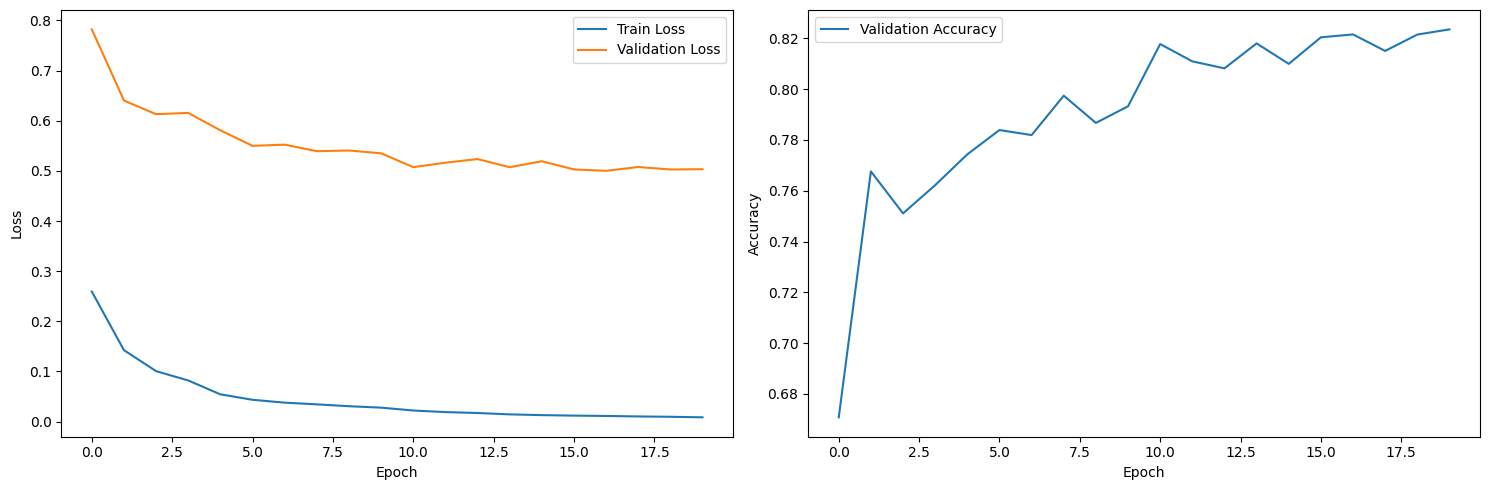

In [16]:
if __name__ == "__main__":
    train_model()